<a href="https://colab.research.google.com/github/sharvil10/COT5600_quantum_computing/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HW 3

### Problem 1 

In [0]:
#Import all depndencies
import numpy as np
from numpy import linalg as LA

**Fourier matrix**

Let $\omega=\mathrm{exp}(2\pi i/N)$ be the $N$th root of unity.  The Fourier matrix of size $N$ is the matrix $F_N=(q_{k,\ell})\in\mathbb{C}^{N\times N}$ whose entries are given by
$$q_{k,\ell}=\frac{1}{\sqrt{N}} \omega^{k \cdot \ell}$$ for $k, \ell \in \{0,\ldots,N-1\}$.

Using numpy, implement the function ```get_fourier_matrix``` that creates the Fourier matrix of size $N$.

Compute the eigenvalues of eigenvectors of the Fourier matrix.  

To check that your code is correct, you should verify the following properties:

- the Fourier matrix is unitary 
- the fourth power of $F_N^4$ is equal to the identity matrix
- its eigenvalues are $1, i, -1, -i$ (the multiplicities of these eigenvalues are given on the wikipedia page [discrete fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) in section *eigenvalues and eigenvectors*)

In [0]:
def get_fourier_matrix(N):
  omega = np.exp(2*np.pi*1j / N) 
  grid = np.meshgrid(range(N), range(N), indexing = 'ij')#Creating k,l for each position in matrix
  i, j = grid[0], grid[1]
  mat = omega ** (i * j)#omega^(k,l) vectorized!
  mat /= np.sqrt(N)
  return mat

def test_unitary(mat):
  N = mat.shape[0]
  norm = np.conj(mat).T @ mat
  return np.allclose(np.eye(N), norm) #Checking if the M.H * M is identity

def test_nth_power(mat, power = 4):
  N = mat.shape[0]
  return np.allclose(np.eye(N), LA.matrix_power(mat, power)) #Matrix's 4th power

def test_eigen(mat):
  w, v = LA.eig(mat)
  for w_i in w:
    if not np.any(np.isclose(w_i, [-1, 1, 1j, -1j])):#Checking if eigenvalue belongs to 1, -1, 1j or -1j
      return False
  return True


def test_fourier_mat(mat):
  assert test_unitary(mat), "Matrix {} is not unitary".format(mat)
  assert test_nth_power(mat), "F^4 is not identity for F: {}".format(mat)
  assert test_eigen(mat), "Eigen values have some values other than 1, -1, 1j, -1j."
  print("All tests passed!")

In [0]:
N = 8
F_mat = get_fourier_matrix(N)
test_fourier_mat(F_mat)

All test passed!


**Cyclic shift matrix**

The cyclic shift matrix is the matrix $P_N=(p_{k,\ell}\in\mathbb{C}^{N\times N}$ whose entries are given by

$$ p_{k,\ell} = 1 \mbox{ if } \ell = k + 1 \pmod{N} $$

$$ p_{k,\ell} = 0 \mbox{ if } \ell \neq k + 1 \pmod{N} $$

Using numpy, implement the function ```get_cyclic_shift_matrix``` that create the cyclic shift matrix of size $N$.

Compute the eigenvalues of $P_N$.

To show that your code is correct, you should verify the following properties:

- the cyclic shift matrix is unitary
- the $N$th power of the cyclic shift matrix is the identity matrix
- the eigenvalues of the cyclic shift matrix are $N$th roots of unity
- the cyclic shift matrix is diagonalized by the Fourier matrix, that is, $F_N^\dagger P_N F_N$ is diagonal.

In [0]:
def get_cyclic_matrix(N):
  mat = np.zeros((N, N))
  idx = (np.arange(N) + 1) % N
  mat[np.arange(N), idx] = 1
  return mat

def test_diag(mat):
  N = mat.shape[0]
  F = get_fourier_matrix(N)
  mat = np.conj(F).T @ mat @ F
  return np.allclose(mat, np.diag(np.diag(mat)))

def test_cyclic_mat(mat):
  N=mat.shape[0]
  assert test_unitary(mat), "Matrix {} is not unitary".format(mat)
  assert test_nth_power(mat, N), "F^N is not identity for F: {}".format(mat)
  assert test_diag(mat), "Diagonalization failed"
  print("All tests passed!")

In [0]:
cycl_mat = get_cyclic_matrix(N)
test_cyclic_mat(cycl_mat)

All test passed!


### Problem 2

Using Qiskit IBM Q Experience, implement the quantum phase estimation circuit with 3-bit precision.  

This quantum circuit is explained on pages 110-113 (Inverse Fourier transform for 3 qubits) of the lecture slides.

Write a function that create the state

$$ 
\frac{1}{\sqrt{2}} ( |0\rangle + e^{2\pi i 2^2 \varphi} |1\rangle ) \otimes 
\frac{1}{\sqrt{2}} ( |0\rangle + e^{2\pi i 2^1 \varphi} |1\rangle ) \otimes 
\frac{1}{\sqrt{2}} ( |0\rangle + e^{2\pi i 2^0 \varphi} |1\rangle ) 
$$

for arbitrary $\varphi\in [0,1)$. 

(This is the state that we would obtain by 
- preparing the three control bits in the $|+\rangle$ state 
- applying the control power of $U^{2^2}, U^{2^1}, U^{2^0}$ gates

assuming that the target qubit is in state $|\psi\rangle$ and $U|\psi\rangle=e^{2 \pi i \varphi} |\psi\rangle$.)

You can preprare the initial state applying ```U1``` gates on qubits prepared $|+\rangle$. See [Qiskit U1 gate documentation](https://qiskit.org/documentation/stubs/qiskit.extensions.U1Gate.html). 

The controlled $R_k^\dagger$ gates occuring in the inverse Fourier transform circuit can be realized with the help of controlled ```U1``` gates.  

In [0]:
#Installing qiskit
#!pip install qiskit
#!pip install qiskit-terra[visualization]
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_histogram

In [0]:
def prepare_states(circ1, angle):
  #angle will define the U-gate. 
  circ1.x(3)#|1> is an eigenvector of the U-gate
  for i in range(3):
    circ1.h(i)#apply Hadamard 3 times
  
  for i in range(3):#Iterate over all control qbits
    k_pow = 2 ** i
    for j in range(k_pow):#Have to apply 2^k times
      circ1.cu1(angle, 2 - i, 3)

In [0]:
def inv_fourier(circ1):
  for i in range(3):#Iterate over all qbits
    for j in range(i):#For i=0 we don't have any R_k, i=1 we have 1 and so on...
      k = i - j + 1
      angle = np.pi / (2**(k-1))
      circ1.cu1(-angle, j, i)
    circ1.h(i)

First we will try out the T-gate. 

T = $\begin{bmatrix} 1 & 0 \\ 0 & e^{i\frac{\pi}{4}} \end{bmatrix}$

It changes the phase of eigenvector $|1\rangle$ by \\
$T|1\rangle = e^{2\pi i\varphi}|1\rangle$ where $\varphi = \frac{1}{8}$ \\

So we expect the answer to be 001 as $\varphi = 0.001$ in binary means $\frac{1}{8}$ in decimals.

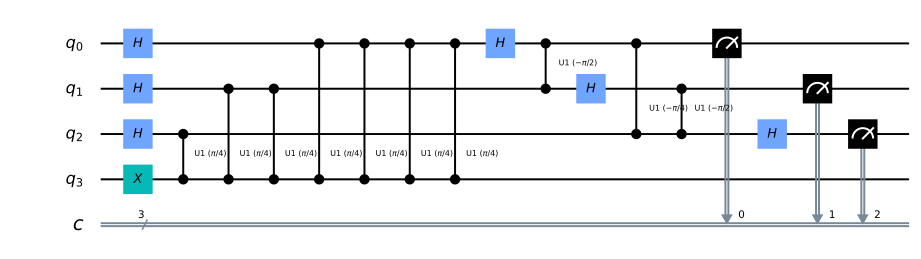

In [0]:
circ = QuantumCircuit(4, 3) #3-bit precision so 3 classical bits will be needed for measurement
angle = np.pi / 4. #T-gate
prepare_states(circ, angle)
inv_fourier(circ)
for n in range(3):
    circ.measure(n,n) #Reverse the measures as qiskit shows them in reverse.
circ.draw(output = 'mpl')

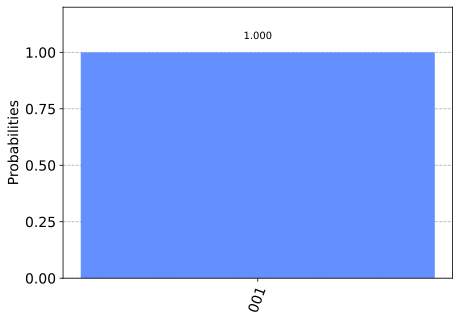

In [0]:
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(circ, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

As we see above the answer is correct for T-gate